In [41]:
import importlib

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


## Testing how we can set up the domain for the tests

#### Birds
Need to consider
- Flock size
- Flock shape (V-shape?)
- Spacing between birds
- Number of birds



#### Obstacles
Need to consider
- Number of obstaces
- Spacing of obstacles
- Grid type (even across/offset)
- 

# Bird Flocks

- Average length is 0.64m
- Wingspan is 137.5cm

Let's assume they want at least 2 m between the center of each bird

Assume that birds fly in lines with a slight V-formation

Old functions

In [42]:
def add_noise_theta(theta, eta, N):
    '''
    Update theta with a random amount of noise between -eta/2 and eta/2
    '''
    theta += eta * (np.random.rand(N, 1) - 0.5)
    
    return theta

def initialize_birds_random(N, L, v0):
    '''
    Set initial positions, direction, and velocities 
    '''
    # Bird positions
    x = np.random.rand(N, 1)*L
    y = np.random.rand(N, 1)*L

    # Bird velocities
    theta = 2 * np.pi * np.random.rand(N, 1)
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    return x, y, vx, vy, theta


def initialize_birds_square(N, L, v0, theta_start, eta):
    '''
    Set initial positions as a uniform placement starting at the edge of the box.
    Set direction and velocity to be uniform with a small amount of noise 
    '''
    
    # Set bird initial flock as a square
    N_per_side = int(np.sqrt(N))
    
    # Midpoint of area 
    midpoint = L//2
    
    # Define the x locations (start in centre of perimeter)
    half_length = N_per_side // 2
    start = midpoint - half_length
    x_locs = np.arange(start, start + N_per_side)
    
    # Define the y locations (start from bottom)
    y_locs = np.arange(0, N_per_side)
    
    # Define bird starting points
    # Initialise lists
    x = []
    y = []
    
    for x_loc in x_locs:
        for y_loc in y_locs:
            x.append([x_loc])
            y.append([y_loc])
    
    # Turn into numpy arrays
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    
    # Bird Angle
    # Make all birds same starting angle
    theta = np.ones((len(x),1))*theta_start
    
    # Add noise
    theta = add_noise_theta(theta, eta, N)
    
    
    # Bird velocities
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)
    
    
    return x, y, vx, vy, theta

Triangle flock shape

In [43]:
def initialize_birds_triangle(N, L, v0, theta_start, eta):
    '''
    Set initial positions as a triangle starting at the bottome edge of the simulation box.
    Set direction and velocity to be uniform with a small amount of noise 
    
    Triangle is shaped based on an angle (be an obstuse angle). Make it an obtuse isoceles triangle
    Birds should spaced by 2 m in both the x and y directions
    '''
    min_distance = 2
    top_angle = np.radians(150)

    # Properties of obtuse isoceles triangle
    bottom_angle = (np.pi - top_angle)/2

    # Initialise parameters and lists
    x, y = [], []
    total_birds = 0
    row = 0
    x_row_0 = L // 2

    # Loop through rows of triangle, starting with 1 in first row. 

    while total_birds < N:
        # y position of this row
        y_pos = -row * min_distance

        # base length of triangle in this row
        base_length = 2*abs(y_pos) / np.tan(bottom_angle)
        half_base = base_length/2
        
        # number of birds that can fit in the current row
        birds_in_row = int(base_length / min_distance) + 1

        # limit the number of birds in the row if total exceeds N
        if total_birds + birds_in_row > N:
            birds_in_row = N - total_birds
        
        # add birds around the symmetric line of triangle
        # go from left to right
        x_row_start = x_row_0 - half_base
        
        for i in range(birds_in_row):
            x.append(x_row_start + (i * min_distance))
            y.append(y_pos)
        
        # update total birds and row counters
        total_birds += birds_in_row
        row += 1

    # Turn into numpy arrays
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    
    # shift all y_pos up so birds start within the domain
    y = y + (row-1)*min_distance

    # Bird Angle
    # Make all birds the same starting angle
    theta = np.ones((len(x), 1)) * theta_start

    # Add noise to angle
    theta = add_noise_theta(theta, eta, N)

    # Bird velocities
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)
    
    return x, y, vx, vy, theta


Plot it

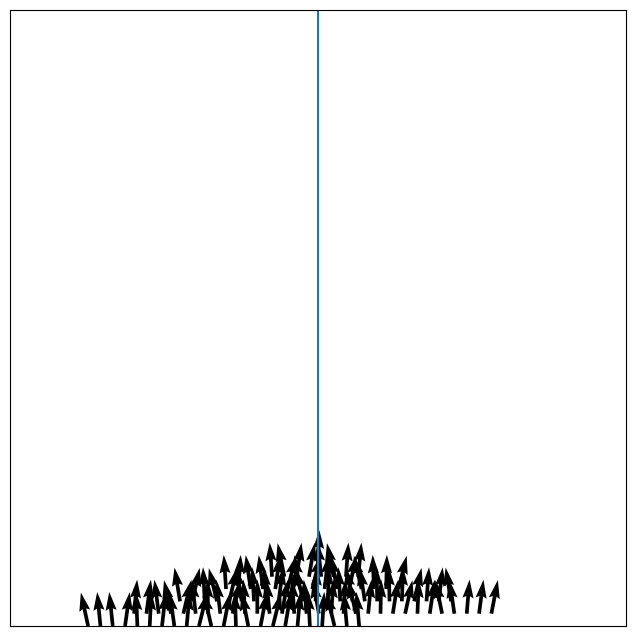

In [44]:
N = 100
L = 100

v0 = 1.0      # velocity of birds (constant)
eta = 0.5  
theta_start = np.pi/2

# Set up a figure
fig, ax = plt.subplots(figsize = (8,8))


# x, y, vx, vy, theta = initialize_birds_square(N, L, v0, theta_start, eta)
x, y, vx, vy, theta = initialize_birds_triangle(N, L, v0, theta_start, eta)


# Plot initial quivers
q = ax.quiver(x, y, vx, vy)

# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.axvline(L//2)

# Make Obstacle grids

Could make functions for 
- Rectangles
- Cicles (not realistic in real-world)
- Ellipse

Function to make rectangular objects

In [45]:
def make_rectangular_obstacle(x_centre, y_centre, L1, L2, n=25):
    '''
    Returns x,y points defining a rectangular-shaped obstacle
    '''
    
    # Number of points per side
    points_per_side = n // 4
    
    # Half lengths for width and height
    l1 = L1 / 2
    l2 = L2 / 2
    
    # Corners of the rectangle
    top_left = [x_centre - l1, y_centre + l2]
    top_right = [x_centre + l1, y_centre + l2]
    bottom_left = [x_centre - l1, y_centre - l2]
    bottom_right = [x_centre + l1, y_centre - l2]
    
    # Initialize lists for x and y points
    x_points = []
    y_points = []
    
    # Generate points along each side
    # Top edge (left to right)
    x_points.extend(np.linspace(top_left[0], top_right[0], points_per_side))
    y_points.extend([top_left[1]] * points_per_side)
    
    # Right edge (top to bottom)
    x_points.extend([top_right[0]] * points_per_side)
    y_points.extend(np.linspace(top_right[1], bottom_right[1], points_per_side))
    
    # Bottom edge (right to left)
    x_points.extend(np.linspace(bottom_right[0], bottom_left[0], points_per_side))
    y_points.extend([bottom_left[1]] * points_per_side)
    
    # Left edge (bottom to top)
    x_points.extend([bottom_left[0]] * points_per_side)
    y_points.extend(np.linspace(bottom_left[1], top_left[1], points_per_side))
    
    return x_points, y_points

Function to make circular objects

In [46]:
def make_circular_obstacle(x_centre, y_centre, R, n=20):
    '''
    Returns x,y points defining a circular-shaped obstacle
    '''
    angles = np.linspace(0, 2 * np.pi, n)
    
    x = x_centre + R*np.cos(angles)
    y = y_centre + R*np.sin(angles)
    
    return x, y

Function to make elliptical objects

In [47]:
def make_elliptical_obstacle(x_centre, y_centre, Rx, Ry, n=20):
    '''
    Returns x,y points defining a elliptical-shaped obstacle
    '''
    angles = np.linspace(0, 2 * np.pi, n)
    
    x = x_centre + Rx*np.cos(angles)
    y = y_centre + Ry*np.sin(angles)
    
    return x, y

# Rectangle Grid

<!-- ![](images/grid_spacing_goals.png) -->
Trying to make grids that look like this

<img src="images/grid_spacing_goals.png" alt="Example Plot" width="800">


In [48]:
def get_obstacle_rectangle_grid(L, nrows, ncols, x_spacing, y_spacing, offset, beta):
    '''
    Define a grid of centre points for the obstacles in a rectangle pattern from a pre-specified x and y spacing.
    
    Considers the top half of the domain to be the "wind farm area"
    
    Makes the grid from the centre of this "wind farm area"
    
    x_spacing, y_spacing -> distances between centre points of obstacles
    
    offset -> y offset applied to every second column
    
    beta -> amount of shear applied to angle the grid (in radians). 0 applies no shear.
    '''
    
    # Defining the "wind farm area"
    # in the x direction it goes from 0 to L
    # in the y direction it goes from L/2 to L

    # min_x, max_x = L/4, 3*L/4
    min_x, max_x = 0, L
    min_y, max_y = L/4, L
    
    midpoint_x = min_x + (max_x - min_x)/2
    midpoint_y = min_y + (max_y - min_y)/2
    
    # Define the grid now
    # Centre x and y locations around midlines
    total_x_distance = ncols*x_spacing
    x_locs = np.arange(min_x, min_x + total_x_distance, x_spacing)
    temp_mid = np.mean(x_locs)

    x_locs = x_locs + midpoint_x - temp_mid

    total_y_distance = nrows*y_spacing
    y_locs = np.arange(min_y, min_y + total_y_distance, y_spacing)
    temp_mid = np.mean(y_locs)

    y_locs = y_locs + midpoint_y - temp_mid
    
    # Initialise x and y arrays
    x_centres, y_centres = [], []
    
    # Define the grid locations
    for i, x in enumerate(x_locs):
        for y in y_locs:
            x_centres.append(x)
            
            # Handle the offset
            if not i % 2:
                y_centres.append(y)
            else:
                y_centres.append(y + offset)

    # Apply the shear (shear to the right)
    shear_matrix = np.array([[1, np.tan(beta)],[0, 1]]) # Shear defined here
    grid_points = np.stack([x_centres, y_centres], axis=1) # Combine locations together to apply shear
    
    # Apply the shear
    sheared_grid = np.dot(grid_points, shear_matrix.T)

    # Split back into separate lists
    x_sheared, y_sheared = sheared_grid[:, 0], sheared_grid[:, 1]

    # Move x locations back such it is still centered around the symmetric line
    current_midpoint = (max(x_sheared) + min(x_sheared))/2
    x_offset = midpoint_x - current_midpoint # distance from current centre to desired centre
    x_sheared = x_sheared + x_offset
    
    # Overwrite the variables to return, note that if beta=0 then x_sheared is the same as x_centres, y_sheared is the same as y_centres
    x_centres, y_centres = x_sheared, y_sheared
    return x_centres, y_centres


Get list of obstacles

In [49]:
def get_obstacles(L, num_obstacles, nrows, ncols, x_spacing, y_spacing, offset, beta, Rx, Ry, n):
    '''
    Call the obstacle functions and get lists of their x, y points
    '''
    x_centres, y_centres = get_obstacle_rectangle_grid(L, nrows, ncols, x_spacing, y_spacing, offset, beta)
    
    # Initalise lists
    x_obstacle_list = []
    y_obstacle_list = []
    
    for i in range(num_obstacles):
        # Make rectangular obstacles
        # x_obs, y_obs = make_rectangular_obstacle(x_centres[i], y_centres[i], L1=10, L2=2, n=25)
        # x_obs, y_obs = make_circular_obstacle(x_centres[i], y_centres[i], R=2.5, n=20)
        x_obs, y_obs = make_elliptical_obstacle(x_centres[i], y_centres[i], Rx, Ry, n)
        
        x_obstacle_list.append(x_obs)
        y_obstacle_list.append(y_obs)
    
    # Concatenate lists for analysis
    x_obstacle = np.concatenate(x_obstacle_list)
    y_obstacle = np.concatenate(y_obstacle_list)
    
    return x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle

# Plot the obstacles

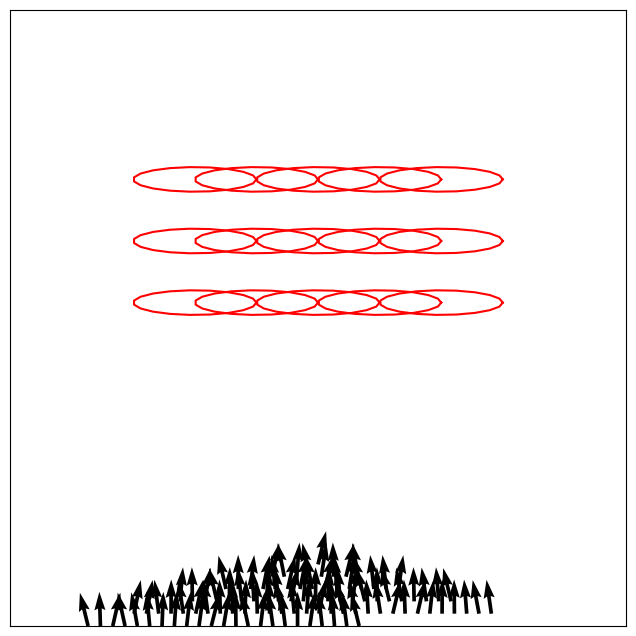

In [50]:
N = 100
L = 100

v0 = 1.0      # velocity of birds (constant)
eta = 0.5  
theta_start = np.pi/2

# Set up a figure
fig, ax = plt.subplots(figsize = (8,8))

# Obstacles
num_obstacles = 15
nrows = 3
ncols = 5

x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle = get_obstacles(L, num_obstacles, nrows, ncols, x_spacing=10, y_spacing=10, offset=0, beta=np.radians(0), Rx=10, Ry=2, n=20)

# Plot obstacle(s) - Plot the "list" to visualise the different obstaclces properly
for xx, yy in zip(x_obstacle_list, y_obstacle_list):
    ax.plot(xx, yy, 'r-')


# Birds
# x, y, vx, vy, theta = initialize_birds_square(N, L, v0, theta_start, eta)
x, y, vx, vy, theta = initialize_birds_triangle(N, L, v0, theta_start, eta)


# Plot initial quivers
q = ax.quiver(x, y, vx, vy)

# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# # Save figure
# name = 'elliptical'
# plt.savefig(f"images/example_{name}_turbine_test_set_up.png", dpi=300, bbox_inches='tight')  # 

# Calculating the area of a wind farm

Essentially just trying to get L so we can define the size of the area

| **Parameter**                  | **Value**                             | **Unit**   | **Constant (Y/N)** | **Source**                                                                                       |
|--------------------------------|---------------------------------------|------------|---------------------|-------------------------------------------------------------------------------------------------|
| **Number of Turbines**         | 30-60 (medium-sized wind farms)        | Count      | N                   | Wikipedia, but find something better                                                                                               |
| **Rotor Diameter**             | ~100                                  | m          | Y                   | Approximately average                                                                            |
| **Rotor Width/Nacelle**        | ~10                                   | m          | Y                   | [Investigation Effects of Different Wind Turbine Designs](https://www.researchgate.net/publication/342643389_Investigation_Effects_of_Different_Wind_Turbine_Designs_on_Air_Flow_and_Generated_Power) |
| **Rotor Spacing - Side**       | 3 to 5                                | diameters  | N                   | Masters, Gilbert M (2003)                                                                      |
| **Rotor Spacing - Behind**     | 5 to 9                                | diameters  | N                   | Masters, Gilbert M (2003)                                                                      |
| **Area of Wind Farm**          | Dependent on the max spacings         | m²         | Y                   | Calculate it                                                                                    |
| **Type of Bird**               | Barnacle Goose                        | -          | Y                   | -                                                                                               |
| **Number of Birds in Flock**   | A few hundred                         | -          | Y                   | -                                                                                               |
| **Size of Bird**               | 0.64 length, 1.375 wingspan           | m          | Y                   | -                                                                                               |
| **Spacing Between Birds**      | 2 m between                           | m          | Y                   | -                                                                                               |
| **Speed of Birds**             | 17.38 ± 2.08                          | m/s        | Y                   | -                                                                                               |
| **Wind Speed**                 | Cut-in: 4, Rated: 13, Cut-out: 25     | m/s        | N                   | [Siemens SWT-6.0-154](https://en.wind-turbine-models.com/turbines/657-siemens-swt-6.0-154)     |
| **Wind Direction**             | North                                 | rad        | Y                   | -                                                                                               |


In [51]:
# The maximum parameters in terms of size
turbines = 60
diameter = 100

rotor_spacing_side = 5 #5 diameters to the side
rotor_spacing_behind = 9 #9 diameters behind

# To include the width of rotors and to leave extra space on the sides of analysis area, have additions to the rotor spacings 
x_spacing = (rotor_spacing_side + 2)*diameter
y_spacing = (rotor_spacing_behind + 1)*diameter

# Let's consider the rectangular grid of 6 rows x 10 columns
nrows = 6
ncols = 10

x_dimension = ncols*x_spacing
y_dimension = nrows*y_spacing

print(x_dimension,y_dimension)

print(x_dimension*y_dimension)

7000 6000
42000000


## Try plotting the scenario

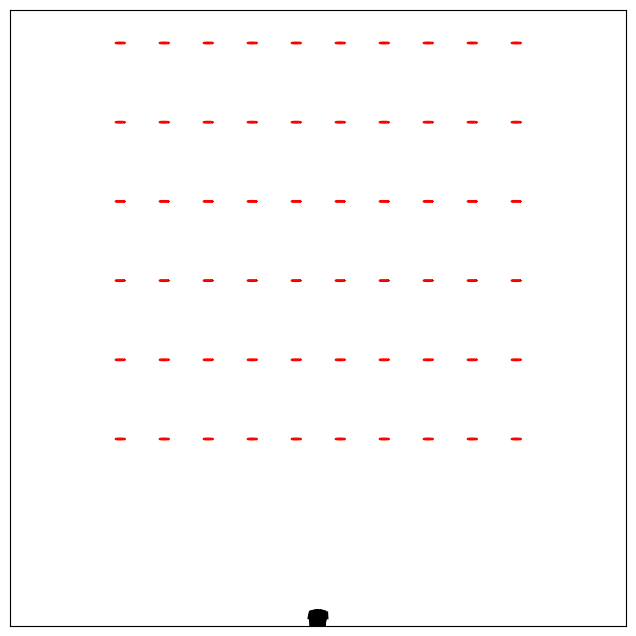

In [52]:
N = 500 #num birds
L = 7000 #Sides of box, m

v0 = 1.0      # velocity of birds (constant)
eta = 0.5  
theta_start = np.pi/2

# Obstacles
nrows = 6
ncols = 10
num_obstacles = nrows*ncols

diameter = 100
width = 10
rotor_spacing_side = 5 #5 diameters to the side
rotor_spacing_behind = 9 #9 diameters behind

x_spacing = rotor_spacing_side * diameter
y_spacing = rotor_spacing_behind * diameter
offset = 0
# offset = y_spacing/2
beta = np.radians(0)
Rx = diameter/2
Ry = width/2
n = 25

# Set up a figure
fig, ax = plt.subplots(figsize = (8,8))


x_obstacle_list, y_obstacle_list, x_obstacle, y_obstacle = get_obstacles(L, num_obstacles, nrows, ncols, x_spacing, y_spacing, offset, beta, Rx, Ry, n)

# Plot obstacle(s) - Plot the "list" to visualise the different obstaclces properly
for xx, yy in zip(x_obstacle_list, y_obstacle_list):
    ax.plot(xx, yy, 'r-')


# Birds
# x, y, vx, vy, theta = initialize_birds_square(N, L, v0, theta_start, eta)
x, y, vx, vy, theta = initialize_birds_triangle(N, L, v0, theta_start, eta)


# Plot initial quivers
q = ax.quiver(x, y, vx, vy)

# Set figure parameters
ax.set(xlim=(0, L), ylim=(0, L))
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# # Save figure
# name = 'elliptical'
# plt.savefig(f"images/example_{name}_turbine_test_set_up.png", dpi=300, bbox_inches='tight')  # 

# Making bird speed, v0, a function of dt (timestep)

The function *update_positions* handles the v*dt steps, therefore we can just set $v_0$ = 17.38 m/s 

# How long to run simulation?

We should consider how long it would take for the the birds to fly across the whole domain as if there were no obstacles

In [53]:
L = 7000
v0 = 17.38

T = L/v0

print(f'Minimum simulation time: {round(T)} s')

# To account for stragglers, randomness, add an extra 10S
simulation_T = T + 10
print(f'Simulation time: {round(simulation_T)} s')


Minimum simulation time: 403 s
Simulation time: 413 s


How many time steps does that equal?